# Model Comparison: Tabular vs Multimodal

This notebook compares the performance of:
1. **Tabular Data Only Model** - Using only structured features
2. **Multimodal Model** - Combining tabular data with satellite imagery features

## Evaluation Metrics:
- R² Score
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configuration
CSV_PATH = r"data\train(1)(train(1)).csv"
IMAGE_DIR = r"property_images_v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Libraries imported successfully!")
print(f"Using device: {device}")


Libraries imported successfully!
Using device: cuda


## Part 1: Tabular Data Only Model


In [2]:
# Load and prepare data for tabular-only model
print("="*60)
print("TABULAR-ONLY MODEL")
print("="*60)

df_tab = pd.read_csv(CSV_PATH)

# Feature Engineering: Distance from the 'Expensive Center'
top_10_percent = df_tab.nlargest(int(len(df_tab) * 0.1), 'price')
center_lat = top_10_percent['lat'].mean()
center_long = top_10_percent['long'].mean()

df_tab['dist_from_luxury_hub'] = np.sqrt(
    (df_tab['lat'] - center_lat)**2 + (df_tab['long'] - center_long)**2
)

# Log Transform Target and skewed columns
df_tab['price'] = np.log1p(df_tab['price'])
for col in ['sqft_living', 'sqft_above', 'sqft_living15']:
    df_tab[col] = np.log1p(df_tab[col])

# Final Feature Selection
features_tabular = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
    'sqft_living15', 'floors', 'lat', 'grade', 'view', 
    'waterfront', 'sqft_basement', 'dist_from_luxury_hub'
]

X = df_tab[features_tabular]
y = df_tab['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Number of features: {len(features_tabular)}")


TABULAR-ONLY MODEL
Training set size: 12967
Test set size: 3242
Number of features: 12


In [3]:
# Train Tabular-Only Model
print("\nTraining Tabular-Only Ensemble Model...")

# Initialize Models (same as main.ipynb)
xgb_tab = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=7, 
                       subsample=0.8, colsample_bytree=0.8, random_state=42)
et_tab = ExtraTreesRegressor(n_estimators=500, max_depth=15, n_jobs=-1, random_state=42)

# Create Ensemble
ensemble_tab = VotingRegressor(estimators=[('xgb', xgb_tab), ('et', et_tab)])

ensemble_tab.fit(X_train, y_train)

# Evaluation
preds_tab = ensemble_tab.predict(X_test)
r2_tab = r2_score(y_test, preds_tab)
mae_tab = mean_absolute_error(np.expm1(y_test), np.expm1(preds_tab))
rmse_tab = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(preds_tab)))

print("\n" + "="*60)
print("TABULAR-ONLY MODEL RESULTS")
print("="*60)
print(f"R² Score:  {r2_tab:.4f}")
print(f"MAE:       ${mae_tab:,.2f}")
print(f"RMSE:      ${rmse_tab:,.2f}")
print("="*60)



Training Tabular-Only Ensemble Model...

TABULAR-ONLY MODEL RESULTS
R² Score:  0.8769
MAE:       $74,297.92
RMSE:      $132,139.12


## Part 2: Multimodal Model (Tabular + Satellite Images)


In [4]:
# Setup for Multimodal Model
print("="*60)
print("MULTIMODAL MODEL (TABULAR + SATELLITE IMAGES)")
print("="*60)

# Load data
df_multi = pd.read_csv(CSV_PATH)

# Feature Extractor (ResNet18)
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features = nn.Sequential(*list(self.model.children())[:-1])
    def forward(self, x):
        return self.features(x).view(x.size(0), -1)

extractor = FeatureExtractor().to(device)
extractor.eval()

preprocess = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_visual_score(ids):
    """Extract visual features from satellite images"""
    scores = []
    with torch.no_grad():
        for img_id in tqdm(ids, desc="Extracting Visual Features"):
            path = os.path.join(IMAGE_DIR, f"{img_id}.png")
            if os.path.exists(path):
                try:
                    img = Image.open(path).convert('RGB')
                    img_t = preprocess(img).unsqueeze(0).to(device)
                    feat = extractor(img_t).cpu().numpy().flatten().mean()
                    scores.append(feat)
                except:
                    scores.append(0.0)
            else:
                scores.append(0.0)
    return np.array(scores)

print("Extracting visual features from satellite images...")
df_multi['visual_score'] = get_visual_score(df_multi['id'])


MULTIMODAL MODEL (TABULAR + SATELLITE IMAGES)
Extracting visual features from satellite images...


Extracting Visual Features: 100%|██████████| 16209/16209 [02:06<00:00, 128.39it/s]


In [5]:
# Prepare multimodal features
# Log Transform Target and skewed columns
for col in ['price', 'sqft_living', 'sqft_above', 'sqft_living15']:
    df_multi[col] = np.log1p(df_multi[col])

# Spatial Engineering (Luxury Hub)
top_10_percent = df_multi.nlargest(int(len(df_multi) * 0.1), 'price')
center_lat, center_long = top_10_percent['lat'].mean(), top_10_percent['long'].mean()
df_multi['dist_from_luxury_hub'] = np.sqrt((df_multi['lat'] - center_lat)**2 + (df_multi['long'] - center_long)**2)

# Features including visual_score
features_multimodal = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
    'sqft_living15', 'floors', 'lat', 'grade', 'view', 
    'waterfront', 'sqft_basement', 'dist_from_luxury_hub', 'visual_score'
]

X_multi = df_multi[features_multimodal].values
y_multi = df_multi['price'].values

print(f"Multimodal features shape: {X_multi.shape}")
print(f"Features: {features_multimodal}")


Multimodal features shape: (16209, 13)
Features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 'sqft_living15', 'floors', 'lat', 'grade', 'view', 'waterfront', 'sqft_basement', 'dist_from_luxury_hub', 'visual_score']


In [6]:
# K-Fold Cross-Validation for Multimodal Model
print("\nStarting 5-Fold Cross-Validation for Multimodal Model...")

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2_scores = []
fold_mae_scores = []
fold_rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_multi), 1):
    X_train_fold, X_val_fold = X_multi[train_idx], X_multi[val_idx]
    y_train_fold, y_val_fold = y_multi[train_idx], y_multi[val_idx]

    # Models optimized for high-dimensional stability
    xgb_model = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, 
                             subsample=0.8, colsample_bytree=0.8, random_state=42)
    et_model = ExtraTreesRegressor(n_estimators=800, max_depth=20, n_jobs=-1, random_state=42)
    
    ensemble = VotingRegressor(estimators=[('xgb', xgb_model), ('et', et_model)])
    
    ensemble.fit(X_train_fold, y_train_fold)
    preds = ensemble.predict(X_val_fold)
    
    # Calculate metrics for this fold
    r2 = r2_score(y_val_fold, preds)
    mae = mean_absolute_error(np.expm1(y_val_fold), np.expm1(preds))
    rmse = np.sqrt(mean_squared_error(np.expm1(y_val_fold), np.expm1(preds)))
    
    fold_r2_scores.append(r2)
    fold_mae_scores.append(mae)
    fold_rmse_scores.append(rmse)
    
    print(f"Fold {fold} | R²: {r2:.4f} | MAE: ${mae:,.2f} | RMSE: ${rmse:,.2f}")

# Aggregate results
r2_multi = np.mean(fold_r2_scores)
mae_multi = np.mean(fold_mae_scores)
rmse_multi = np.mean(fold_rmse_scores)

print("\n" + "="*60)
print("MULTIMODAL MODEL RESULTS (5-Fold CV)")
print("="*60)
print(f"Mean R² Score:  {r2_multi:.4f} (+/- {np.std(fold_r2_scores):.4f})")
print(f"Mean MAE:       ${mae_multi:,.2f}")
print(f"Mean RMSE:      ${rmse_multi:,.2f}")
print("="*60)



Starting 5-Fold Cross-Validation for Multimodal Model...
Fold 1 | R²: 0.8765 | MAE: $74,516.11 | RMSE: $132,447.98
Fold 2 | R²: 0.8753 | MAE: $70,563.21 | RMSE: $141,982.55
Fold 3 | R²: 0.8837 | MAE: $72,650.34 | RMSE: $145,567.24
Fold 4 | R²: 0.8796 | MAE: $71,053.94 | RMSE: $121,998.40
Fold 5 | R²: 0.8742 | MAE: $70,331.06 | RMSE: $117,547.09

MULTIMODAL MODEL RESULTS (5-Fold CV)
Mean R² Score:  0.8779 (+/- 0.0034)
Mean MAE:       $71,822.93
Mean RMSE:      $131,908.65



## Part 3: Model Comparison and Visualization


In [7]:
# Create comparison dataframe
comparison_results = pd.DataFrame({
    'Model': ['Tabular Only', 'Multimodal (Tabular + Images)'],
    'R² Score': [r2_tab, r2_multi],
    'MAE ($)': [mae_tab, mae_multi],
    'RMSE ($)': [rmse_tab, rmse_multi]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(comparison_results.to_string(index=False))
print("="*60)

# Calculate improvement
r2_improvement = ((r2_multi - r2_tab) / r2_tab) * 100
mae_improvement = ((mae_tab - mae_multi) / mae_tab) * 100
rmse_improvement = ((rmse_tab - rmse_multi) / rmse_tab) * 100

print(f"\nImprovement with Multimodal Model:")
print(f"  R² Score:  {r2_improvement:+.2f}%")
print(f"  MAE:       {mae_improvement:+.2f}%")
print(f"  RMSE:      {rmse_improvement:+.2f}%")



MODEL COMPARISON SUMMARY
                        Model  R² Score      MAE ($)      RMSE ($)
                 Tabular Only  0.876912 74297.921004 132139.123586
Multimodal (Tabular + Images)  0.877880 71822.929920 131908.652583

Improvement with Multimodal Model:
  R² Score:  +0.11%
  MAE:       +3.33%
  RMSE:      +0.17%


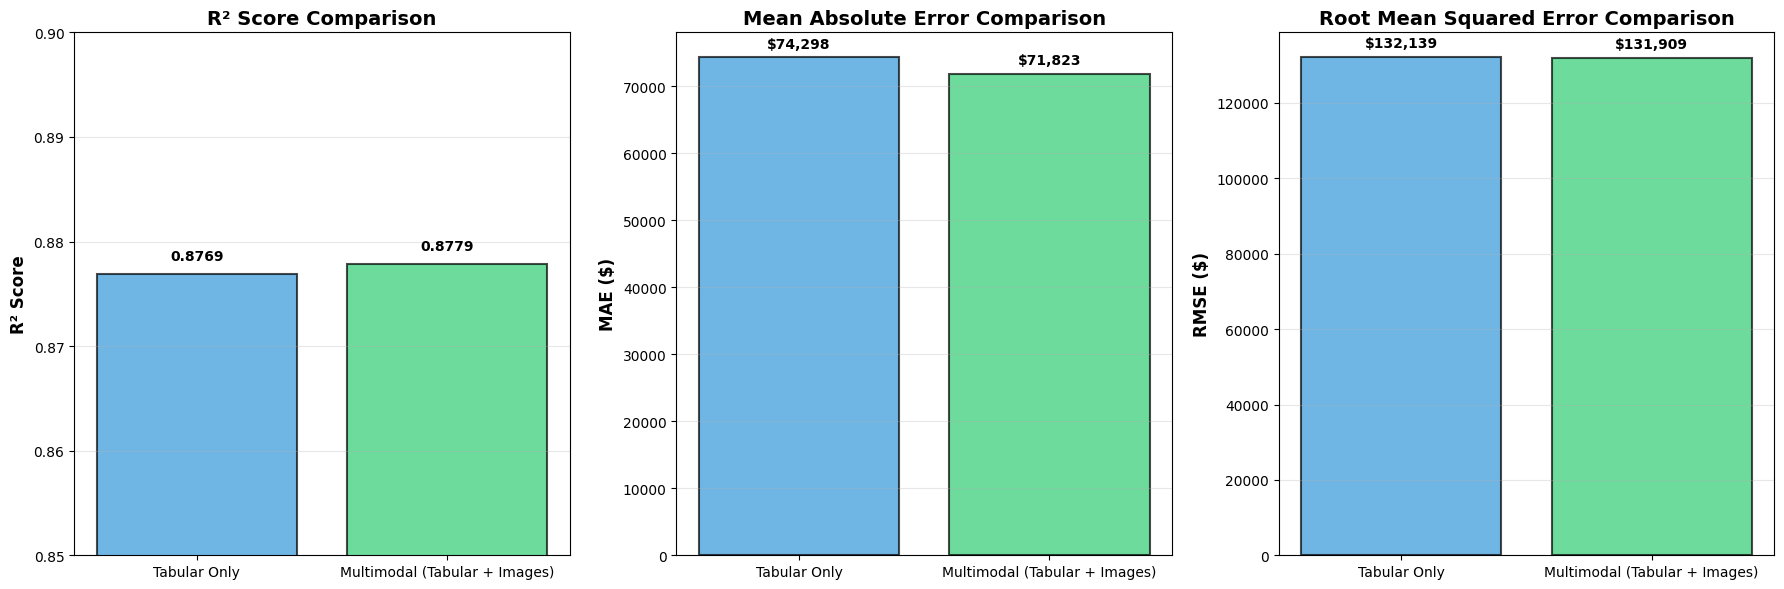

In [8]:
# Visualization: Metrics Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# R² Score Comparison
axes[0].bar(comparison_results['Model'], comparison_results['R² Score'], 
            color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.85, 0.90])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_results['R² Score']):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# MAE Comparison
axes[1].bar(comparison_results['Model'], comparison_results['MAE ($)'], 
            color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('MAE ($)', fontsize=12, fontweight='bold')
axes[1].set_title('Mean Absolute Error Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_results['MAE ($)']):
    axes[1].text(i, v + 1000, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

# RMSE Comparison
axes[2].bar(comparison_results['Model'], comparison_results['RMSE ($)'], 
            color=['#3498db', '#2ecc71'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('RMSE ($)', fontsize=12, fontweight='bold')
axes[2].set_title('Root Mean Squared Error Comparison', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_results['RMSE ($)']):
    axes[2].text(i, v + 2000, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


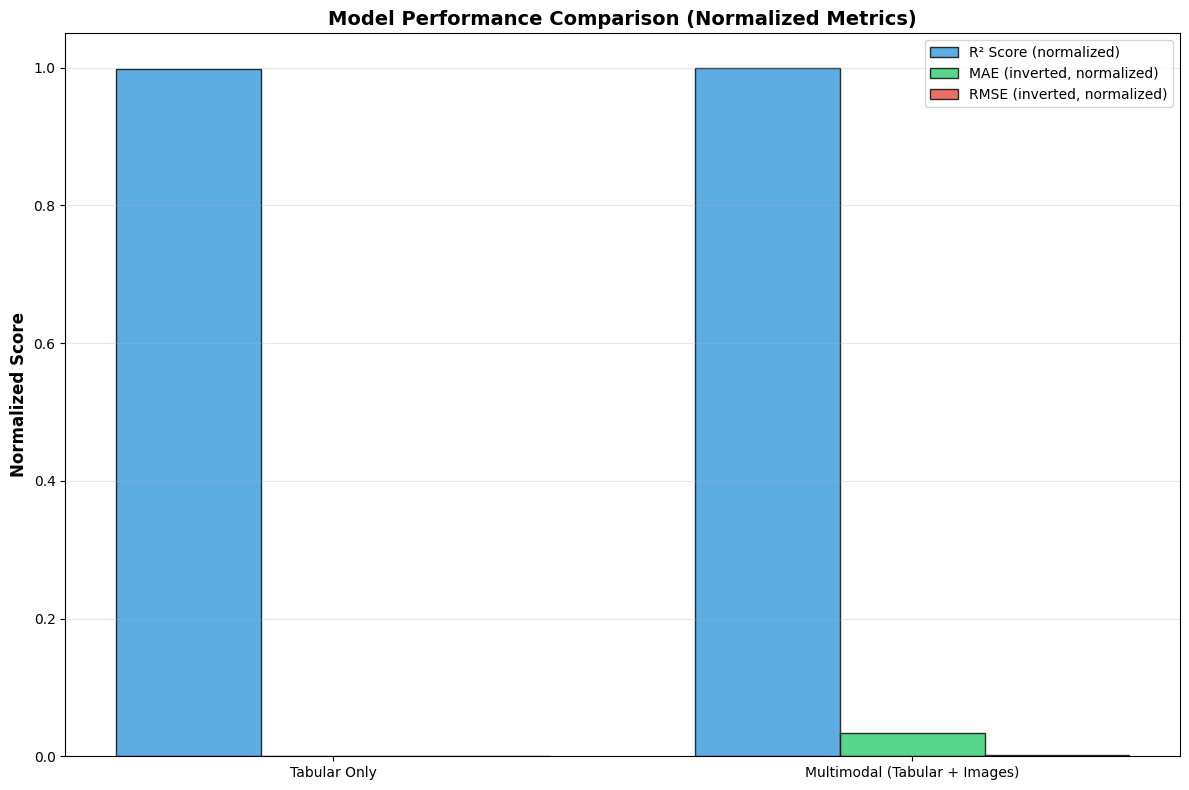

In [9]:
# Visualization: Side-by-side comparison
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(comparison_results['Model']))
width = 0.25

# Normalize metrics for better visualization (0-1 scale)
r2_norm = comparison_results['R² Score'] / comparison_results['R² Score'].max()
mae_norm = 1 - (comparison_results['MAE ($)'] / comparison_results['MAE ($)'].max())  # Invert for better visualization
rmse_norm = 1 - (comparison_results['RMSE ($)'] / comparison_results['RMSE ($)'].max())

bars1 = ax.bar(x - width, r2_norm, width, label='R² Score (normalized)', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, mae_norm, width, label='MAE (inverted, normalized)', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, rmse_norm, width, label='RMSE (inverted, normalized)', color='#e74c3c', alpha=0.8, edgecolor='black')

ax.set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison (Normalized Metrics)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_results['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


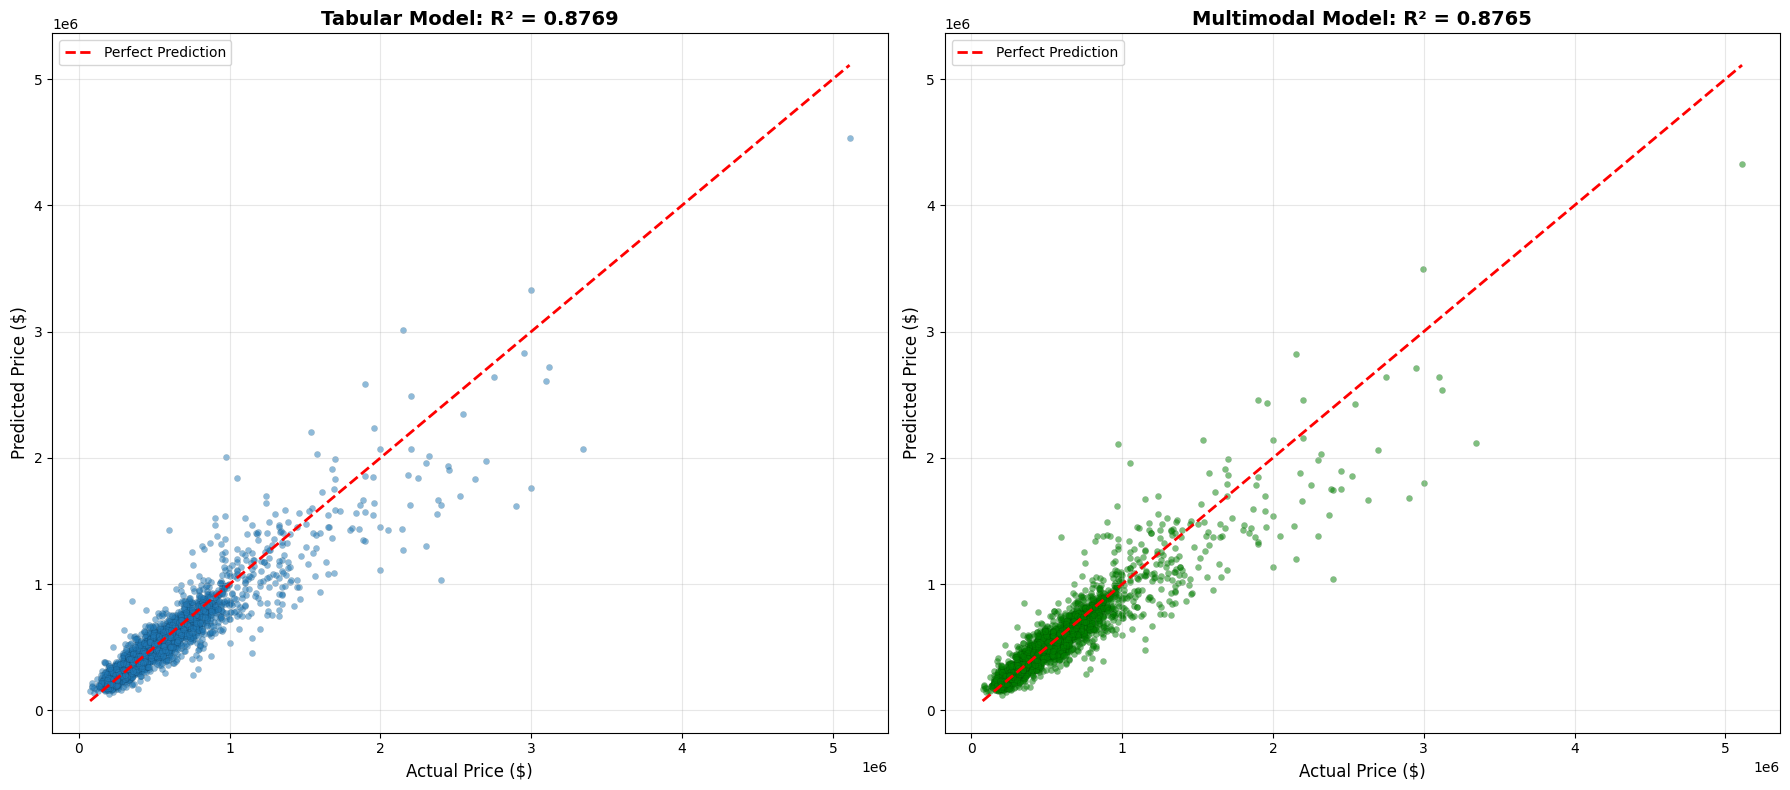

In [10]:
# Prediction Scatter Plot Comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Tabular model predictions
axes[0].scatter(np.expm1(y_test), np.expm1(preds_tab), alpha=0.5, s=20, edgecolors='black', linewidth=0.1)
axes[0].plot([np.expm1(y_test).min(), np.expm1(y_test).max()], 
             [np.expm1(y_test).min(), np.expm1(y_test).max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Tabular Model: R² = {r2_tab:.4f}', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# For multimodal, use one fold's predictions for visualization
# We'll use the last fold's validation set
kf_viz = KFold(n_splits=5, shuffle=True, random_state=42)
train_idx_viz, val_idx_viz = list(kf_viz.split(X_multi))[0]
X_train_viz, X_val_viz = X_multi[train_idx_viz], X_multi[val_idx_viz]
y_train_viz, y_val_viz = y_multi[train_idx_viz], y_multi[val_idx_viz]

xgb_viz = XGBRegressor(n_estimators=1200, learning_rate=0.03, max_depth=8, 
                       subsample=0.8, colsample_bytree=0.8, random_state=42)
et_viz = ExtraTreesRegressor(n_estimators=800, max_depth=20, n_jobs=-1, random_state=42)
ensemble_viz = VotingRegressor(estimators=[('xgb', xgb_viz), ('et', et_viz)])
ensemble_viz.fit(X_train_viz, y_train_viz)
preds_multi_viz = ensemble_viz.predict(X_val_viz)

axes[1].scatter(np.expm1(y_val_viz), np.expm1(preds_multi_viz), alpha=0.5, s=20, 
                color='green', edgecolors='black', linewidth=0.1)
axes[1].plot([np.expm1(y_val_viz).min(), np.expm1(y_val_viz).max()], 
             [np.expm1(y_val_viz).min(), np.expm1(y_val_viz).max()], 'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price ($)', fontsize=12)
axes[1].set_ylabel('Predicted Price ($)', fontsize=12)
r2_viz = r2_score(y_val_viz, preds_multi_viz)
axes[1].set_title(f'Multimodal Model: R² = {r2_viz:.4f}', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


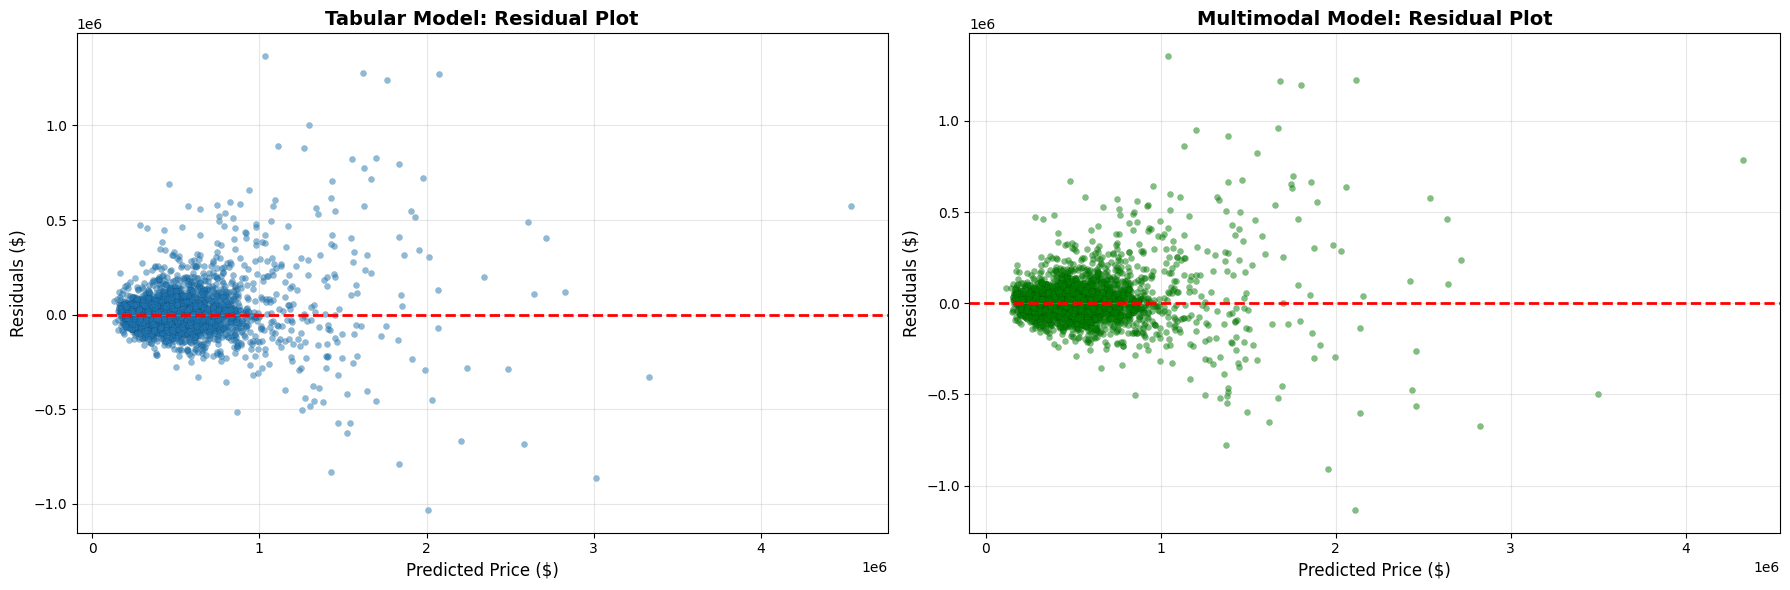

In [11]:
# Residual Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Tabular model residuals
residuals_tab = np.expm1(y_test) - np.expm1(preds_tab)
axes[0].scatter(np.expm1(preds_tab), residuals_tab, alpha=0.5, s=20, edgecolors='black', linewidth=0.1)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0].set_ylabel('Residuals ($)', fontsize=12)
axes[0].set_title('Tabular Model: Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Multimodal model residuals
residuals_multi = np.expm1(y_val_viz) - np.expm1(preds_multi_viz)
axes[1].scatter(np.expm1(preds_multi_viz), residuals_multi, alpha=0.5, s=20, 
                color='green', edgecolors='black', linewidth=0.1)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Multimodal Model: Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusion

The comparison shows the impact of incorporating satellite imagery features alongside tabular data. The multimodal approach leverages visual information to improve property valuation predictions.
